In [53]:
# library

import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as plt
import seaborn as sns


import time
from datetime import datetime

import networkx as nx
import re
import json

In [3]:
# styling for graph
sns.set_style('darkgrid')

General conclusions:
- There seems to be a magic walk-away point after 100 days.
- Proposal topic do not impact voting participation.
- There is some concetration of voting power in cluster 3/ 

### Governance Participation Analysis (issue 5): How can voter participation be increased? 

see section 1, section 2

### Governance Participation Analysis (issue 7)

see section 3, section 4


### Governance Participation Analysis (issue 17)

- Participation Rate Analytics: Section 7
- voter drop-off: Section 4
- coalition analysis: section 8
- influence of topics on participation: section 5


### Coalision analysis
Investigate if the most frequent proposal submitters are also acting as delegators. *Not investigated in depth*

Cluster Analysis: *Not investigated in depth*
Determine if there are any obvious clusters of individuals who support each other.(not done)
Investigate if these clusters are also influencing proposal votes. (not done)

Voting Influence Assessment:
Analyze the extent of influence these clusters have in terms of voting power. *See Section 8*




## Section 1: What is the level of participation in governance?

In [378]:
# address who participated either in snapshot or Tally

#snapshot participation
file_path = 'data/votes_snapshot.json' 
with open(file_path, "r", encoding='utf-8-sig') as file:
    data = json.load(file, strict=False)

snapshot = pd.DataFrame.from_dict(data)
snapshot = snapshot.rename(columns = {'p.name':'p.title'})
snapshot['platform'] = 'snapshot'

#tally participation

file_path = 'data/voting_tally.json' 
with open(file_path, "r", encoding='utf-8-sig') as file:
    data = json.load(file, strict=False)

tally = pd.DataFrame.from_dict(data)
tally['platform'] = 'tally'


Combine the data from tally and snapshot to get all the addresses in one file

In [379]:
print(snapshot.columns)
print(tally.columns)

Index(['n.address', 'p.id', 'p.title', 'v.choice', 'platform'], dtype='object')
Index(['n.address', 'p.id', 'p.title', 'v.choice', 'platform'], dtype='object')


In [380]:
vparticipation = pd.concat([snapshot, tally])
vparticipation = vparticipation.rename(columns = {'n.address':'address'})
print(vparticipation.shape)
vparticipation.head()

(391633, 5)


address  \
0  0x1653ff6cd12628ae47fced55f65082fe4390e605   
1  0xe719529be204d3c1243952fb5722e0cfaa0b2be5   
2  0x01f761805c90bc8abfaf504075afdb87e1e5dc08   
3  0x99a671eb43c694fb5a4e7e40f64570567c96dddf   
4  0xc24fe6f2bae027aeee47390be73d121f18f51bdb   

                                                p.id  \
0  0x24344ab10eb905a4d7fa5885c6f681290e765a08a5f5...   
1  0x24344ab10eb905a4d7fa5885c6f681290e765a08a5f5...   
2  0x24344ab10eb905a4d7fa5885c6f681290e765a08a5f5...   
3  0x24344ab10eb905a4d7fa5885c6f681290e765a08a5f5...   
4  0x24344ab10eb905a4d7fa5885c6f681290e765a08a5f5...   

                                             p.title v.choice  platform  
0  [Non-constitutional] Proposal to fund Pluralit...        1  snapshot  
1  [Non-constitutional] Proposal to fund Pluralit...        1  snapshot  
2  [Non-constitutional] Proposal to fund Pluralit...        1  snapshot  
3  [Non-constitutional] Proposal to fund Pluralit...        1  snapshot  
4  [Non-constitutional] Proposal to fund Pluralit...        1  snapshot

In [381]:
# descriptive information about addresses

# import data of submitters
file_path = 'data/author_of_prop.json' 
with open(file_path, "r", encoding='utf-8-sig') as file:
    data = json.load(file, strict=False)

authors = pd.DataFrame.from_dict(data)

# import data of funded addresss
file_path = 'data/funded_address.json' 
with open(file_path, "r", encoding='utf-8-sig') as file:
    data = json.load(file, strict=False)

funded = pd.DataFrame.from_dict(data)

# # import data of activity on discourse
file_path = 'data/discourse_activity.json' 
with open(file_path, "r", encoding='utf-8-sig') as file:
    data = json.load(file, strict=False)

forum = pd.DataFrame.from_dict(data)

For each address we are add the following information: 
- how many times submitted a proposal (via file authors)
- how mnay times they got funded (via file funded)
- how much funding they got (via file funded)

Information about forum activity will not be included as we don't have that many people who linked their wallet address to their discourse username. Adding these descriptors would have been nice
- how mnay times they posted in the forum (via file forum)
- total number of likes they got on their posts (via file forum)
- total number of readerscount they got on their posts (via file forum)

In [382]:
# grouping the descriptive variables

authorsActivity = authors[['address', 'prop']].groupby('address').count().reset_index()
authorsActivity = authorsActivity.rename(columns = {'prop':'AuthoringFreq'})
# authorsActivity.head()

fundedActivity = funded[['address', 'propid']].groupby('address').count().reset_index()
fundedActivity = fundedActivity.rename(columns = {'propid':'FundingFreq'})

forumActivity = forum[['address', 'p.category']].groupby('address').count().reset_index()
forumActivity = forumActivity.rename(columns = {'p.category':'ForumFreq'})
# authorsActivity.head()

In [383]:
# adding authoring activity to vparticipation
vparticipation = vparticipation.rename(columns = {'voter': 'address'})

vparticipation = vparticipation.merge(authorsActivity, how = 'outer')
print(vparticipation.shape)
# vparticipation = vparticipation.drop_duplicates()
# print(vparticipation.shape)

vparticipation = vparticipation.merge(fundedActivity, how = 'outer')
print(vparticipation.shape)

vparticipation = vparticipation.merge(forumActivity, how = 'outer')
print(vparticipation.shape)

vparticipation.columns

(391636, 6)
(391681, 7)
(391683, 8)


Index(['address', 'p.id', 'p.title', 'v.choice', 'platform', 'AuthoringFreq',
       'FundingFreq', 'ForumFreq'],
      dtype='object')

The data in vparticipation is missing voting power. We'll add that from another snapshot export. As voting power can increases we will use the average voting power someone received. 

The file `voting_withpropTopic.csv` already contains information from Snapshot including voting power, when a vote was casted, the id of a proposal and the topic for it. 

In [10]:
#load data
# voting = pd.read_csv('data/snapshotarbitrum_master.csv')
voting = pd.read_csv('data/snapshot.csv')
# voting = pd.read_csv('data/voting_party.csv')


In [11]:
# cleaning the dataset. Check it before running this. You might not need all of it

# voting['prop'] = [d.get('id') for d in voting.proposal]
# voting['vp'] = voting['vp']/1000000
# voting = voting.drop(['proposal', 'space'], axis = 1)

# if using: data/voting_withpropTopic.csv
# droping columns that are not needed
# voting['vp'] = voting['vp'] * 1000000
# voting = voting.drop(['Unnamed: 0', 'idcheck'], axis = 1)

# setting type for first and last day
voting['time'] = [datetime.fromtimestamp(s) for s in voting.created]
# voting['time'] = pd.to_datetime(voting['created'], )

# lower case all addresses
voting['address'] = voting['address'].str.lower()

In [384]:
# Calculating time lag between first and last vote

# convert timestamp to time

# df[['time', 'created']].head()

# df[['created', 'voter', 'prop', 'vp']].head()

#length of time between first and last vote
voting['rank'] = voting.groupby('address')['time'].rank(method='first', ascending = True)

#filter for first and last entry in each group
timeactive = voting[['address', 'time', 'vp']].groupby('address').agg(first_date = ('time', 'min'),
                                                            last_date = ('time', 'max'),
                                                            avg_vp = ('vp', 'mean'),
                                                            VotingFrequency = ('address', 'count')).reset_index()
timeactive['time_active'] = timeactive['last_date'] - timeactive['first_date']
timeactive['active_days'] = round((timeactive['time_active']/pd.Timedelta(hours=1))/24,0)
timeactive['inactive'] = ['active' if s > datetime(2024,1,1) else 'inactive' for s in timeactive['last_date'] ]

timeactive['dormant'] = pd.to_datetime('today') - timeactive['last_date']
timeactive['dormant_days'] = round((timeactive['dormant']/pd.Timedelta(hours=1))/24,0)

timeactive.to_csv('data/timeactive.csv', index=False)

In [386]:
# now we are adding to the vparticipation information from timeactive
# print(vparticipation.shape)
vparticipation = vparticipation.merge(timeactive[['avg_vp', 'active_days', 'address']], left_on = 'address', right_on = 'address' , how = 'outer')
print(vparticipation.shape)

vparticipation = vparticipation.drop_duplicates()
# print(vparticipation.shape)

(505599, 10)


In [387]:
print(len(vparticipation[vparticipation['p.id'].isna()]))
print(len(vparticipation[vparticipation['p.id'].isna() == False]))

113966
391356


Delete data for which we don't have complete information

In [388]:
vparticipation = vparticipation[vparticipation['p.id'].isna() == False]

In [389]:
# Code to add proposal topics to voting data = > MOVE THIS CODE TO THE BOTTOM 

# proposals = pd.read_csv('data/prop.csv')

vparticipation['p.title'] = vparticipation['p.title'].str.replace('#', '')
vparticipation['p.title'] = vparticipation['p.title'].str.lower()

patAIP = re.compile("aip")
patNConst = re.compile("non-constitutional")
patConst =  re.compile("constitutional")
patElec = re.compile("election")
patstip = re.compile("stip")

# PropType = []
# for index, row in proposals.iterrows():
#     # print(row['name'])
#     if patAIP.search(row['name']):
#         tmp = 'AIP'
#     elif patNConst.search(row['name']):
#         tmp = 'NConstitutional'
#     elif patConst.search(row['name']):
#         tmp = 'Constitutional'
#     elif patElec.search(row['name']):
#         tmp = 'Election'
#     elif patstip.search(row['name']):
#         tmp = 'STIP'
#     else:
#         tmp = 'other'
#     PropType.append(tmp)

# proposals['Topic'] = PropType

In [390]:
vparticipation['topic'] = ['AIP' if patAIP.search(s) 
                else 'NConstitutional' if patNConst.search(s) 
                else 'Constitutional' if patConst.search(s) 
                else 'Election' if patElec.search(s)
                else 'STIP' if patstip.search(s)
                else 'other' for s in vparticipation['p.title'] ]

In [391]:
# rename address to voter to match with rest of script
vparticipation = vparticipation.rename(columns = {'address':'voter'})

In [392]:
# number unique voters
print("Number of unique voters: ", len(vparticipation.voter.unique()))
print("Number of unique proposals: ", len(vparticipation['p.title'].unique()))

Number of unique voters:  142869
Number of unique proposals:  157


## Section 2: How often does a person vote?

The following calculates how often an address participates in governance, by counting how many address times an address votes on Tally and Snapshot. In the following step, we sum it up by counting how often a specific voting frequency happens on a platform. 

For example 22049 addresss voted only once on Snapshot and 50943 voted once on Tally. On the other end of the spectrum we have 1 addresses that voted 102 times on a Snapshot proposal and 3 addresses that voted 105 times on a Tally proposal. The chart displays the sharp drop of voting frequency. 

In [42]:
tmp = vparticipation[['voter', 'platform']].groupby(['voter', 'platform'], as_index=False).agg(VotingFrequency = ('voter', 'count'))
# print(max(tmp.VotingFrequency))
tmp.sort_values('VotingFrequency', ascending = False).head()
tmp

voter  platform  VotingFrequency
0       0x000000000A38444e0a6E37d3b630d7e855a7cb13     tally                1
1       0x000000006F457c0f8F560333d9c2877287d92a92     tally                1
2       0x0000000188e3604489698eA73DE28524F2beA6C6     tally                1
3       0x00000001985C6A08963eEf53821c78aa84318B42     tally                2
4       0x00000001B01122945D67Cf7c972f1a2063Ca4008     tally                2
...                                            ...       ...              ...
142870  0xfffFF9b1c2c387B1e3D19aF292D91D913374F42b     tally                2
142871  0xfffd05ae9db4d5f4e23e2f37395db2f87359bf5d  snapshot                1
142872  0xfffd5aa5d94d621ecd4b6463a7cf4d5a63d780a0  snapshot                1
142873  0xffff100B0017aCED8E01b8eB0454FE09c43364b9     tally                1
142874  0xffffa65c6c6d8838485c98e8d67f5c4c531df216  snapshot               30

[142875 rows x 3 columns]

In [43]:
tmp = tmp[['platform', 'VotingFrequency', 'voter']].groupby(['VotingFrequency', 'platform']).count().reset_index()
tmp

VotingFrequency  platform  voter
0                  1  snapshot  22049
1                  1     tally  50943
2                  2  snapshot   6124
3                  2     tally  20716
4                  3  snapshot   1606
..               ...       ...    ...
111               99  snapshot      9
112              100  snapshot      2
113              101  snapshot      3
114              102  snapshot      1
115              105  snapshot      3

[116 rows x 3 columns]

Text(0, 0.5, 'Voting Frequency')

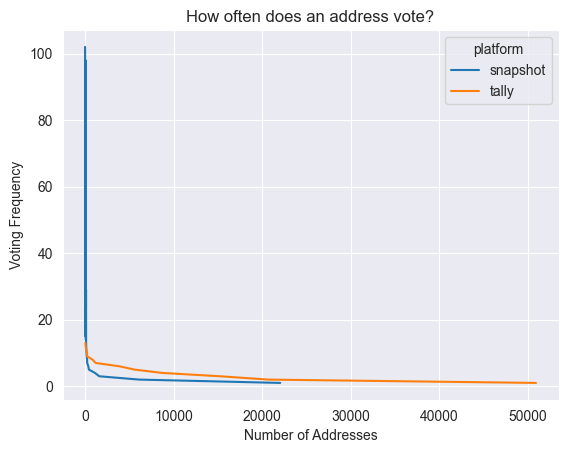

In [44]:
# TODO: make nicer

plot = sns.lineplot(y = 'VotingFrequency', x = 'voter', hue = 'platform', data = tmp)
plot.set_title("How often does an address vote?")
plot.set_xlabel("Number of Addresses")
plot.set_ylabel("Voting Frequency")

As expecting, most people do not vote often. Participation drops quickly on both platforms. 

In [37]:
tmp.sort_values('VotingFrequency', ascending=False).head()

VotingFrequency  platform
115              105  snapshot
114              102  snapshot
113              101  snapshot
112              100  snapshot
111               99  snapshot

In [45]:
tmp.sort_values('VotingFrequency', ascending=True).head()

VotingFrequency  platform  voter
0                1  snapshot  22049
1                1     tally  50943
2                2  snapshot   6124
3                2     tally  20716
4                3  snapshot   1606

## Section 3: Do people with more voting power vote more frequently?

Subsequently, we wanted to figure out if voting frequency could be explained by another variable. We began by looking at voting power. For each address and their voting power, we counted how often they voted. We're doing this analysis only on Snapshot, as we do not have voting power for Tally. 
 
People who have greater voting power are not more likely to vote. This is visible in the scatterplot and confirmed by the low correlation value (-0.01)

In [102]:
# note the different dataset. voting only has snapshot data
tmp = voting[['address', 'vp', 'created', 'proposal']].groupby(['address', 'vp'], as_index=False).agg(VotingFrequency = ('address', 'count')) 
tmp

address           vp  \
0       0x00000000051cbce3fd04148cce2c0adc7c651829  1000.000000   
1       0x000000000a38444e0a6e37d3b630d7e855a7cb13   500.964190   
2       0x000000000a38444e0a6e37d3b630d7e855a7cb13   570.002286   
3       0x000000000a38444e0a6e37d3b630d7e855a7cb13  1570.002286   
4       0x000000006f457c0f8f560333d9c2877287d92a92     5.000000   
...                                            ...          ...   
260133  0xfffd5aa5d94d621ecd4b6463a7cf4d5a63d780a0   129.597835   
260134  0xfffd95bc5a23de688b7f58c8a5e26c2696ff64eb     1.200002   
260135  0xffff3f6e008b09691021e9863d1bfa7a2b9b5689     0.001900   
260136  0xffff3f6e008b09691021e9863d1bfa7a2b9b5689     0.100000   
260137  0xffffa65c6c6d8838485c98e8d67f5c4c531df216     1.151639   

        VotingFrequency  
0                     2  
1                     2  
2                    13  
3                     3  
4                   104  
...                 ...  
260133               12  
260134                8  
260135                4  
260136                7  
260137               92  

[260138 rows x 3 columns]

Text(0, 0.5, 'Voting Frequency')

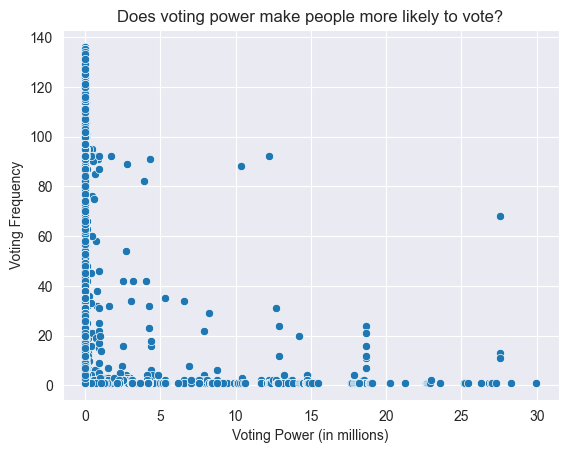

In [103]:
# data
tmp['vp'] = tmp['vp']/1000000 

# creating figure
f, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='both')

plot = sns.scatterplot(x = 'vp', y = 'VotingFrequency', data = tmp, ax = ax)
plot.set_title("Does voting power make people more likely to vote?")
plot.set_xlabel("Voting Power (in millions)") 
plot.set_ylabel("Voting Frequency")

# remove scientific notation

It looks like there is no association between voting power and voting frequency. The correlation between these two variables is extremly weak (-0.02), as can only be seen on the chart below. 

In [104]:
# correlation
tmp[['vp', 'VotingFrequency']].corr(method='pearson')

vp  VotingFrequency
vp               1.000000        -0.018237
VotingFrequency -0.018237         1.000000

AttributeError: 'FacetGrid' object has no attribute 'set_xlabel'

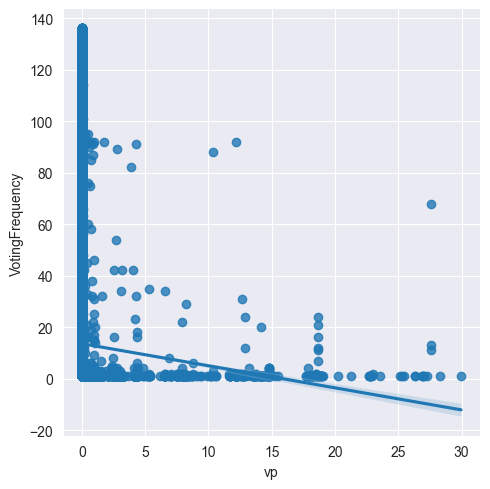

In [105]:
# plt.close() #close previous plots. forget 

# f, ax = plt.subplots()
# ax.ticklabel_format(style='plain', axis='both')

plot = sns.lmplot(data=tmp, x="vp", y="VotingFrequency")
plot.set_titles("Does voting power make people more likely to vote?")
plot.set_xlabels("Voting Power (in millions)") 
plot.set_ylabels("Voting Frequency")


While voting power doesn't influence voting frequency, let's have a look to see if it influences how long a person stays active in the governance process and their inactive time. 

Text(0, 0.5, 'Average voting power (in millions)')

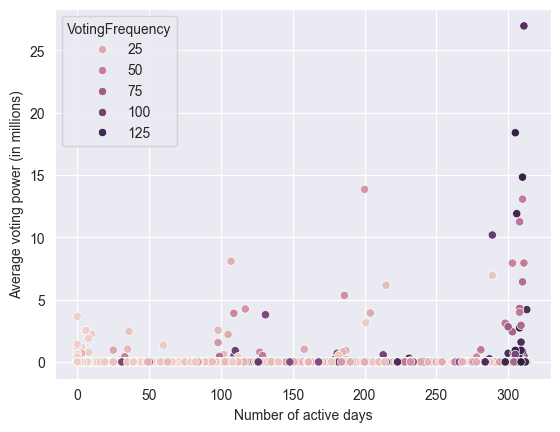

In [107]:
timeactive['avg_vp'] = timeactive['avg_vp'] / 1000000 
f, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='both')

chart = sns.scatterplot(y = 'avg_vp', x = 'active_days', hue = 'VotingFrequency', 
                       data = timeactive, ax = ax)
chart.set_xlabel('Number of active days')
chart.set_ylabel('Average voting power (in millions)')

The darker the circle, the more often the address is voting. There seems to be an association between number of days active and average voting power. However, the correlation doesn't provide evidence for this. 

The correlation analysis shows a positive correlatino between *active days* and *voting frequencye* and a negative correlation between *voting frequency* and *dormant days*. This was to be expected. Unfortunatley this doesn't yet provide ideas into what influences if someone becomes dormant.

In [111]:
timecorr = timeactive[['avg_vp', 'VotingFrequency', 'active_days', 'dormant_days']].corr()

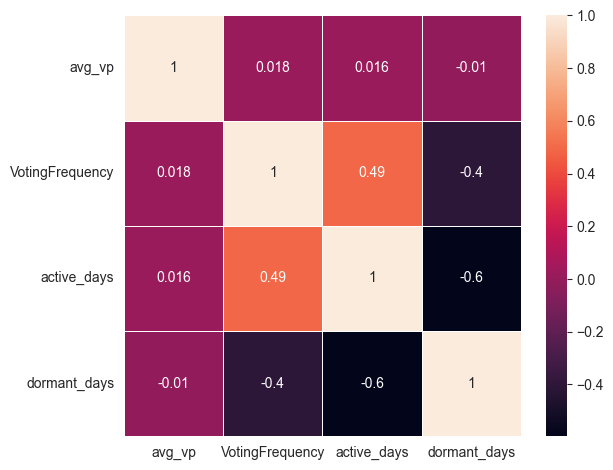

In [124]:
plot = sns.heatmap(timecorr, annot=True, linewidth=.5)
plt.yticks(rotation=0)
plt.tight_layout()

## Section 4: How quickly do people stop voting?

For this we calculated the number of days they have been active (difference between first and last vote) and the time they have been dormant (difference between today 25th March 2024 02:15 UTC and their last vote). This will give insights into when it would be best to engage with people (aka addresses) to keep them active. 

In [67]:
timeactive.head()

address          first_date  \
0  0x00000000051cbce3fd04148cce2c0adc7c651829 2023-09-13 09:25:33   
1  0x000000000a38444e0a6e37d3b630d7e855a7cb13 2023-04-11 09:00:45   
2  0x000000006f457c0f8f560333d9c2877287d92a92 2023-06-21 11:25:48   
3  0x00000001985c6a08963eef53821c78aa84318b42 2023-07-15 08:48:22   
4  0x00000001b01122945d67cf7c972f1a2063ca4008 2023-07-26 07:18:26   

            last_date       avg_vp  VotingFrequency       time_active  \
0 2023-11-06 02:51:07  1000.000000                2  53 days 17:25:34   
1 2024-01-18 17:58:34   728.998053               18 282 days 08:57:49   
2 2023-11-07 12:57:42     5.047795              106 139 days 01:31:54   
3 2023-10-26 17:17:03    14.035672               16 103 days 08:28:41   
4 2023-11-13 22:14:24    22.271422               17 110 days 14:55:58   

   active_days  inactive                  dormant  days_dormant  
0         54.0  inactive 139 days 23:37:36.799476          54.0  
1        282.0    active  66 days 08:30:09.799476         282.0  
2        139.0  inactive 138 days 13:31:01.799476         139.0  
3        103.0  inactive 150 days 09:11:40.799476         103.0  
4        111.0  inactive 132 days 04:14:19.799476         111.0

Text(0, 0.5, 'Average Voting Frequency')

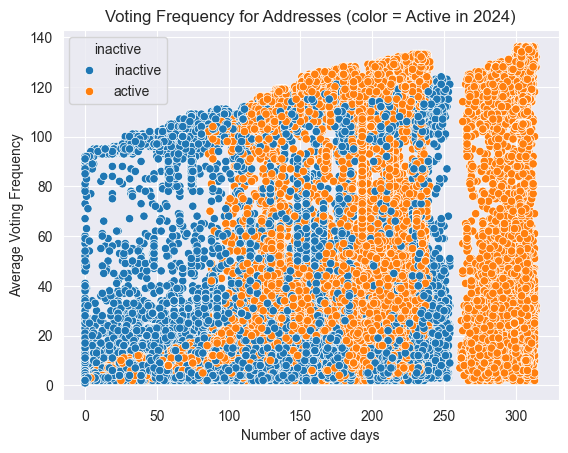

In [68]:
plt = sns.scatterplot(x = 'active_days', y = 'VotingFrequency', hue = 'inactive', data = timeactive)
plt.set_title("Voting Frequency for Addresses (color = Active in 2024)")
plt.set_xlabel('Number of active days')
plt.set_ylabel('Average Voting Frequency')

There is clearly a group of active members who have been active a very long time (more than 250 days). Among the inactive group, there seems to be a sweet spot around 80 days where a person is going to be more like to remain active in 2024. 

Text(0, 0.5, 'Average Voting Frequency')

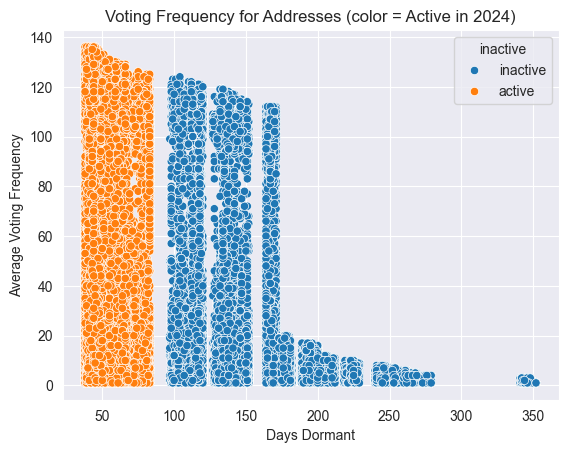

In [76]:
plt = sns.scatterplot(x = 'dormant_days', y = 'VotingFrequency', hue = 'inactive', data = timeactive)
plt.set_title("Voting Frequency for Addresses (color = Active in 2024)")
plt.set_xlabel('Days Dormant')
plt.set_ylabel('Average Voting Frequency')

Looking at the the distribution of active vs inactive members in 2024 and how long they are dormant, it's clear that for those who have not voted in the past 100 days chances that they come back are slim. This implies that any governance reward should be distributed early on, potentially as a slow drip to keep users engage.

## Section 5:  Does the proposal topic make people more likely to vote?

Proposals have been grouped into six categories based on the title of the proposal:
- Arbitrum Improvement Proposal (AIP)
- Non-Constitutional
- Constitutional
- Short-Term Incentive Program (STIP)
- Election
- other

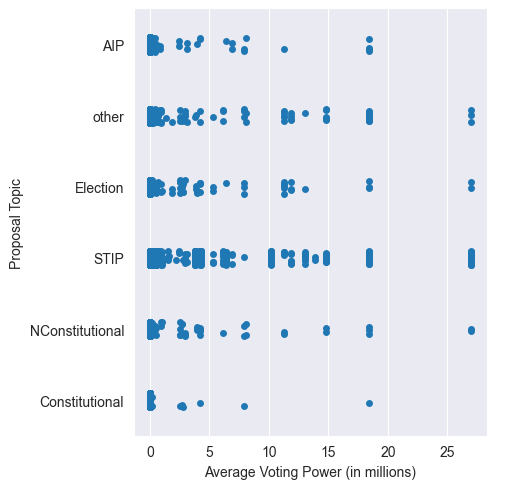

In [196]:
# Does the proposal topic make people more likely to vote?
# y = topic, x = if someone voted ==> want to see if a topic gets more votes => but more STIP proposals than others so result are limited
tmp1 = vparticipation[['voter', 'topic']].groupby(['topic']).agg(VotingFrequency = ('voter', 'size')).reset_index()
tmp1
chart = sns.catplot(y = 'topic', x = 'avg_vp', data = vparticipation)
chart.set_titles('How often do addresses vote on a specific Topic')
chart.set_xlabels('Average Voting Power (in millions)')
chart.set_ylabels('Proposal Topic')


Text(0.5, 0, 'Average active days (median)')

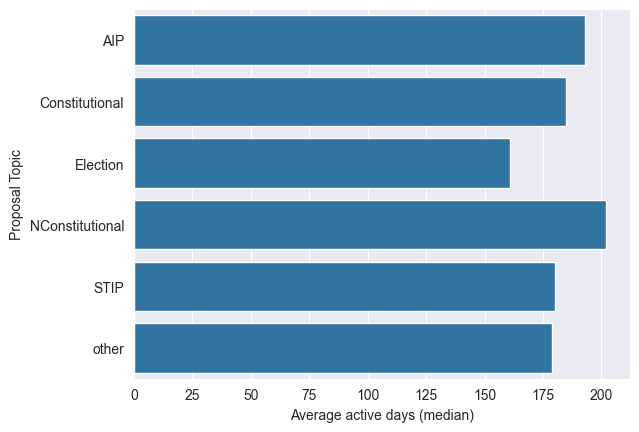

In [199]:
# are those longer active more likely to vote on proposal of a specific topic
tmp2 = vparticipation[['topic', 'active_days']].groupby(['topic']).agg(Avg_activedays = ('active_days', 'median')).reset_index()
tmp2

chart = sns.barplot(y = 'topic', x = 'Avg_activedays', data = tmp2)
chart.set_label('Average active days for voters per proposal topic')
chart.set_ylabel('Proposal Topic')
chart.set_xlabel('Average active days (median)')


Text(0.5, 0, 'Average active days (median)')

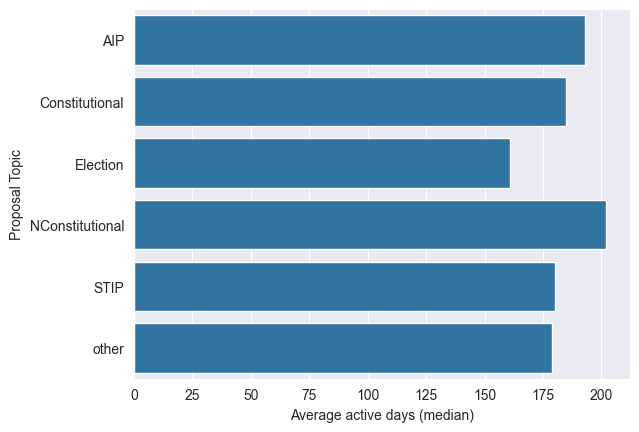

In [201]:
chart = sns.barplot(y = 'topic', x = 'Avg_activedays', data = tmp2)
chart.set_label('Average active days for voters per proposal topic')
chart.set_ylabel('Proposal Topic')
chart.set_xlabel('Average active days (median)')

In [202]:
# combine voting with time active
timeactiveAVG= timeactive.groupby('address').agg(avg_days = ('active_days', 'mean'),avg_dormant = ('dormant_days', 'mean'))

In [209]:
vparticipation = vparticipation.merge(timeactiveAVG, left_on = 'voter', right_on = 'address', how = 'outer')

In [211]:
tmp = vparticipation[['avg_days', 'voter', 'topic']].groupby(['avg_days', 'topic']).agg(nbr_voters = ('voter', 'nunique')).reset_index()
# tmp = tmp.rename(columns = {'voter':'VotingFrequency'})
tmp


avg_days            topic  nbr_voters
0          0.0              AIP         665
1          0.0   Constitutional          13
2          0.0         Election          28
3          0.0  NConstitutional         102
4          0.0             STIP          73
...        ...              ...         ...
1630     313.0         Election           3
1631     313.0  NConstitutional         133
1632     313.0             STIP           5
1633     313.0            other          29
1634     314.0  NConstitutional           4

[1635 rows x 3 columns]

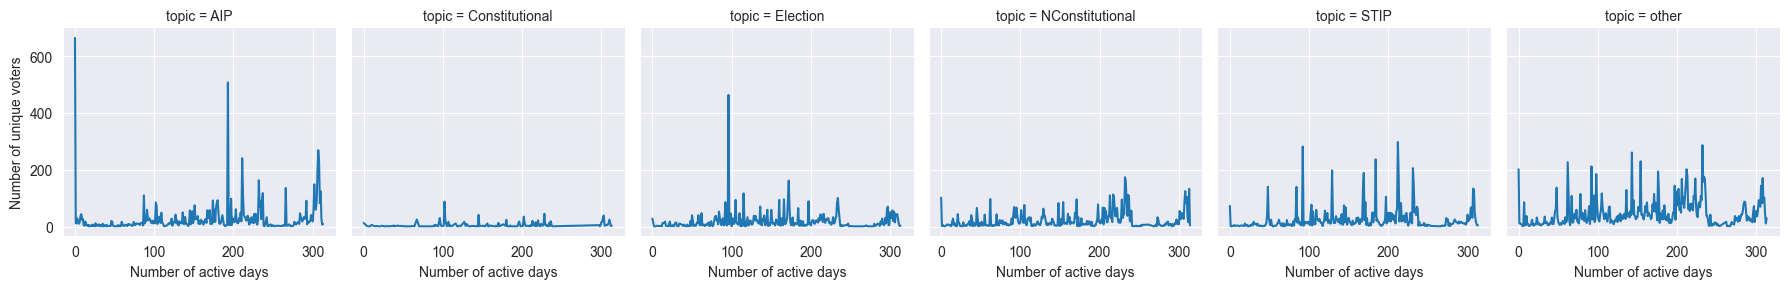

In [212]:
g = sns.FacetGrid(tmp, col = 'topic')
g.map_dataframe(sns.lineplot, x='avg_days', y='nbr_voters', hue = 'topic')
# g.set_titles("Number of Addresses per Topic")
g.set_xlabels('Number of active days')
g.set_ylabels('Number of unique voters')

Looking at the voting pattern across topics for addresses, the following insighs can be gained
- voters who are active for longer are more likely to vote on AIP proposals, reiterating earlier findings
- the topic Election and STIP attract users who are active more than 100 days but less than 200 days.

In [227]:
vparticipation['avg_vp'].mean()

0.040900259628673954

Text(0.5, 0, 'Average voting power')

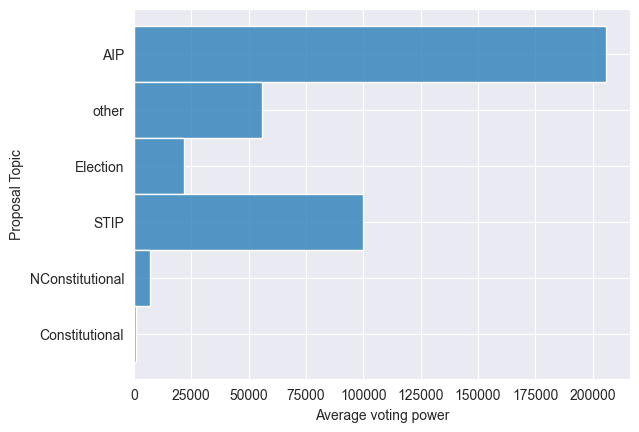

In [229]:
# are those with more vp  more likely to vote on proposal of a specific topic

# tmp3 = vparticipation[['topic', 'avg_vp']].groupby(['topic']).agg(avg_vp = ('avg_vp', 'count')).reset_index()
# # tmp3['avg_vp'] = tmp3['avg_vp']/1000000
# tmp3
chart = sns.histplot(data=vparticipation[['topic', 'avg_vp']], y="topic")
chart.set_label('Number of Votes across Proposal Topic')
chart.set_ylabel('Proposal Topic')
chart.set_xlabel('Average voting power')



STIP is Arbitrum's Short-Term Incentive Program. The first round of voting happend in October 2023. The budget (50 mil ARB) has been exceeded [during round 1](https://forum.arbitrum.foundation/t/stip-round-1-voting-period-update/18725/3). 

More detailed dashboard: Ouroboros Research: [Arbitrum STIP Results](https://docs.google.com/spreadsheets/d/1bdDHV2z5TAWam3hgvuc2Pb8--POlTW9UvbDWxMIMbJU/edit#gid=638031589)

**Insights**

1. Overall, average active time doesn't really influence on what type of proposal you are voting.
2. When looking at individual voting patterns, addresses who have been active a long time (> 250 days) mainly vote on AIP proposals. 
3. People who have ben active a medium amount of time (more than 100 days but less than 250) do not vote on STIP, but active on Election, AIP, Non-Constitutional, and other. 

**Further Question**
1. Are people more likely to vote on a specific type of propsal if they have submitted a proposal?
2. Does voting power play a role?
3. Where most AIP proposals up for vote a long time ago?

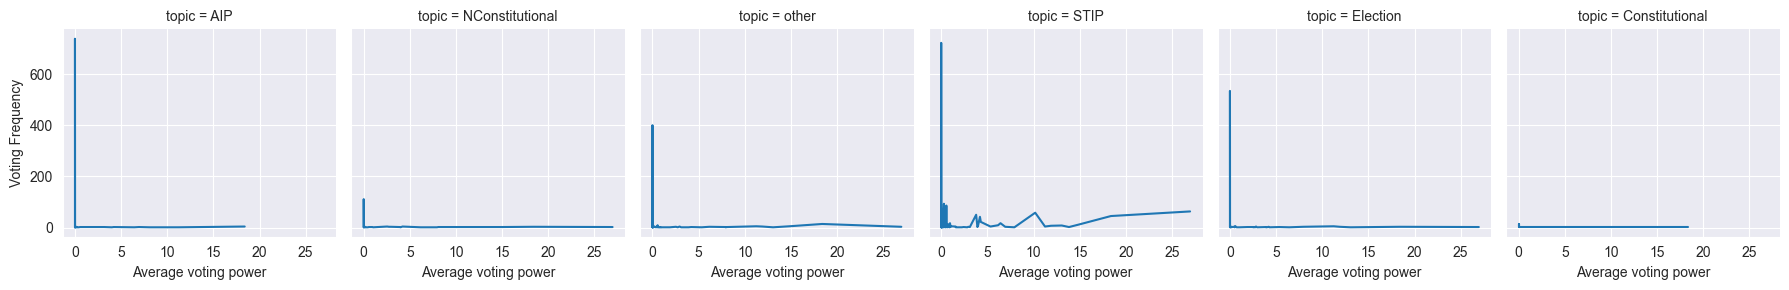

In [238]:
tmp = vparticipation[['avg_vp', 'topic', 'voter']].groupby(['avg_vp', 'topic']).agg(VotingFrequency = ('voter', 'count')).reset_index()
g = sns.FacetGrid(tmp, col = 'topic')
g.map_dataframe(sns.lineplot, x='avg_vp', y='VotingFrequency', hue = 'topic')
# g.set_titles("Number of Addresses per Topic")
g.set_xlabels('Average voting power (in millions)')
g.set_ylabels('Voting Frequency')


Looking at the association between voting power, voting frequency and proposal topic, what jumps out is that for STIP proposals there is first a drop in participation at 2, followed by an increase after a voting power of 15.  

In [240]:
tmp = vparticipation[['active_days', 'topic', 'voter']].groupby(['active_days', 'topic']).agg(VotingFrequency = ('voter', 'count')).reset_index()

# data = tmp[tmp['topic'] != 'STIP']
g = sns.FacetGrid(tmp, col = 'topic')
g.map_dataframe(sns.lineplot, x='active_days', y='VotingFrequency', hue = 'topic')
# g.set_titles("Number of Addresses per Topic")
g.set_xlabels('Number of active days')
g.set_ylabels('Voting Frequency')


Based on this chart, it is clear that people take some time before participating in elections. You can just about see some spokes around the 100 day mark. 
Regarding AIP, there seems to be two groups who are participating: Newcomers to Arbitrum's governance (those active less than 100 days) and old timer (those active more than 200 days). 

Given the activity that STIP proposals generated, the graphs are drawn again below but without STIP.

In [241]:
tmp = vparticipation[['active_days', 'topic', 'voter']].groupby(['active_days', 'topic']).agg(VotingFrequency = ('voter', 'count')).reset_index()

g = sns.FacetGrid(tmp[tmp['topic'] != 'STIP'], col = 'topic')
g.map_dataframe(sns.lineplot, x='active_days', y='VotingFrequency', hue = 'topic')
# g.set_titles("Number of Addresses per Topic")
g.set_xlabels('Number of active days')
g.set_ylabels('Voting Frequency')

Based on this the following insights can be shared:
- Users who are active medium to long term are more likely to vote on AIP proposals
- Users of any age are likely to vote on other proposals
- Users active on a medium term are more like to vote on an Election proposal

To see the patterns better we'll group votin gpower into 4 categories: small, medium, big, huge. 

In [245]:
tmp = vparticipation[['avg_vp', 'topic', 'voter']].groupby(['avg_vp', 'topic']).agg(VotingFrequency = ('voter', 'count')).reset_index()
vpquant = tmp['avg_vp'].quantile(q = np.arange(0.0, 1.0, 0.20)).values
vpquant


array([1.00000000e-24, 1.07869412e-06, 2.09400000e-06, 1.04300000e-05,
       7.53370622e-05])

In [246]:
tmp['VP_group'] = ['small' if s < vpquant[1] else 'medium' if s > vpquant[1] and s < vpquant[2] else 'big' if s > vpquant[2] and s < vpquant[3] else 'huge' for s in tmp['avg_vp']]

tmp2 = tmp[['topic', 'VP_group', 'VotingFrequency']].groupby(['topic', 'VP_group']).agg(sumVotingFreq = ('VotingFrequency','sum')).reset_index()

In [247]:
# plt = sns.scatterplot(x = 'avg_vp', y = 'VotingFrequency', hue = 'Topic', data = tmp[tmp['Topic'] != 'STIP'])
# voting power is too finegrained. do not include in barplot as hue. crashes
plt = sns.barplot(x = 'topic', y = 'sumVotingFreq', hue = 'VP_group', data = tmp2)
plt.set_title("People voting behavior colored by Topic (exc. STIP)")
plt.set_xlabel('Proposal Topic')
plt.set_ylabel('Total Voting Frequency')

Text(0, 0.5, 'Total Voting Frequency')

Looking at the differences between the voting powers within each topic we note that 
- Those with a huge amount of voting power are more likely to cast their vote in en Election or other. 
- Those with a medium voting power are more like to cast their vote in a STIP proposal. They are as likely to do so than those with a huge voting power. 

## Section 6:  Do people vote if they submit something or get funding

In [268]:
# transform nan for authoring and fundingFreq to 0
vparticipation['AuthoringFreq'] = vparticipation['AuthoringFreq'].replace('NaN', 0)
vparticipation['FundingFreq'] = vparticipation['FundingFreq'].replace('NaN', 0)
vparticipation['ForumFreq'] = vparticipation['ForumFreq'].replace('NaN', 0)

This analysis is done on the subset of addressees which have submitted a proposal. Including all the addresses, also those who never submitted, would make the analysis less impactful. This is because the size of the groups is too different. It would be comparing the chances that the US wins a gold medal in the Olympics compared to Ireland. 

Text(0, 0.5, 'Number of Votes casted')

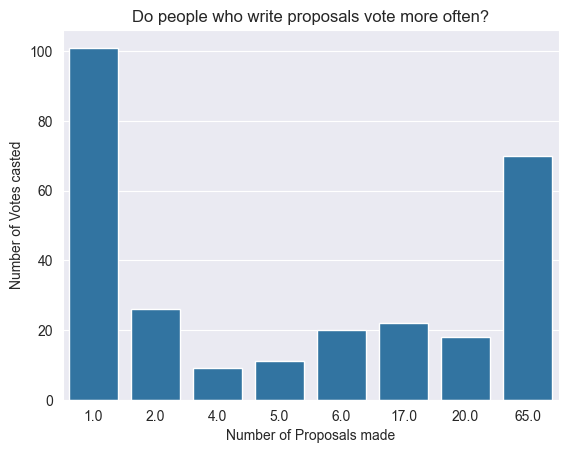

In [272]:
# Do people who write proposals vote more often? Do they have more vp?
tmp = vparticipation[['voter', 'AuthoringFreq']].groupby('AuthoringFreq').count().reset_index()

chart = sns.barplot(x = 'AuthoringFreq', y = 'voter', data = tmp)
chart.set_title('Do people who write proposals vote more often?')
chart.set_xlabel('Number of Proposals made')
chart.set_ylabel('Number of Votes casted')

The largest group is those who made one proposal. Therefore it is not surprising to see this bar to be the highest. Beyond that, it looks like there is a slight association between number of proposals made and number of votes casted. That being said, there is a drop after two proposals. 

In [273]:
# tmp = vparticipation[['avg_vp', 'AuthoringFreq']].groupby('AuthoringFreq').agg(avg_vp = ('avg_vp', 'mean')).reset_index()
# chart = sns.barplot(x = 'AuthoringFreq', y = 'avg_vp', data = tmp)
# chart.set_title('Do people who write proposals have more voting power?')
# chart.set_xlabel('Number of Proposals made')
# chart.set_ylabel('Average voting power (in millions)')

In [275]:
# Do people who write proposals vote more often? Do they have more vp?
tmp = vparticipation[['voter', 'ForumFreq']].groupby('ForumFreq').count().reset_index()

chart = sns.barplot(x = 'ForumFreq', y = 'voter', data = tmp)
chart.set_title('Do people who are more active on the Forum vote more often?')
chart.set_xlabel('Number of Forum Activity')
chart.set_ylabel('Number of Votes casted')

Text(0, 0.5, 'Number of Votes casted')

Unfortunately the dataset is very small for forum posts. This is because of different identifiers used when logging into Discourse compared to Governance tools. 

## Section 7: Comparing Voter Participation between Snapshot and Tally

In [276]:
# vparticipation.groupby(['platform', 'p.title']).apply()
# Voter participation per proposal across Snapshot and Tally
tmp = pd.DataFrame(vparticipation.groupby(['platform','p.title', 'topic'])['voter'].count()/vparticipation.groupby('platform')['voter'].count()).reset_index()


Voter turnout is calculated by counting how many addresses vote on a proposal on Snapshot or Tally and then dividing it by the number of address who vote on that platform. 

In [277]:
tmp

platform                                            p.title  \
0    snapshot   empowering early contributors: the community ...   
1    snapshot                      0xgen stip proposal - round 1   
2    snapshot  [constitutional] changes to the constitution a...   
3    snapshot  [non-constitutional] fund the arbitrum grants ...   
4    snapshot  [non-constitutional] proposal to fund pluralit...   
..        ...                                                ...   
152     tally                              aip: arbos version 11   
153     tally                                            art dra   
154     tally   changes to the constitution and the security ...   
155     tally            experimental delegates incentive system   
156     tally   proposal to establish the arbitrum research &...   

               topic     voter  
0              other  0.006902  
1               STIP  0.006902  
2     Constitutional  0.006916  
3    NConstitutional  0.006902  
4    NConstitutional  0.006025  
..               ...       ...  
152              AIP  0.091584  
153            other  0.126285  
154         Election  0.052093  
155            other  0.006771  
156            other  0.006861  

[157 rows x 4 columns]

Text(0, 0.5, 'Voter turnout')

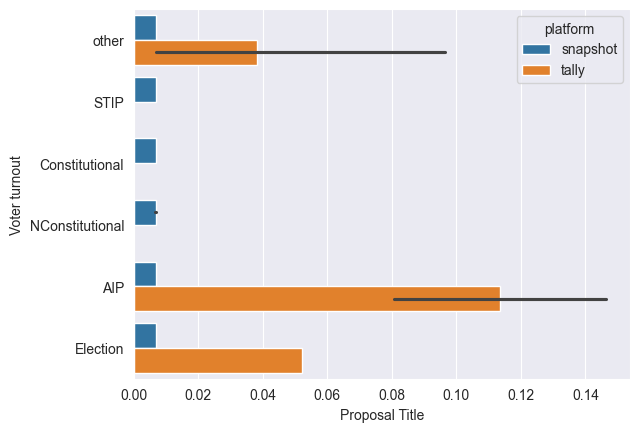

In [278]:
chart = sns.barplot(y = 'topic', x = 'voter', hue = 'platform', data = tmp)
chart.set_label('Voter Participation per Proposal for Snapshot and Tally')
chart.set_xlabel('Proposal Title') # no label.not clear enought
chart.set_ylabel('Voter turnout')

Voter turnout is highest for AIP proposals, with 12%. 

Text(0, 0.5, 'Proposal Title')

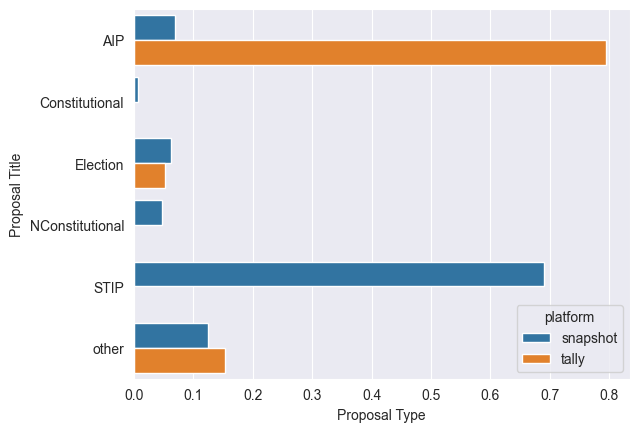

In [279]:
tmp = pd.DataFrame(vparticipation.groupby(['platform', 'topic'])['voter'].count()/vparticipation.groupby('platform')['voter'].count()).reset_index()

chart = sns.barplot(y = 'topic', x = 'voter', hue = 'platform', data = tmp)
chart.set_label('Voter Participation per Proposal for Snapshot and Tally')
chart.set_xlabel('Proposal Type') # no label.not clear enought
chart.set_ylabel('Proposal Title')

The graph summarizes how many people vote on a proposal topic and then calculates the turnout. Thus, on Tally, summing up how many addresses vote on an AIP proposal, and how many addresses vote on any proposal on Tally, nearly 80% of addresses have voted on a AIP proposal. This doesn't mean that 80% of address vote on every AIP proposal, but that across all AIP proposals, 80% of addresses voted.

Taking this into consideration, the following can be said:
- People (aka addresses) are more likely to vote on Tally than on Snapshot. 
On Snapshot addreses are more likely to vote for STIP proposals (as expected give the incentive program). Elections are not fearing well on any platform.

## Section 8: Voting coalitions

To find out about voting coalitions we have looked for communities of voters who vote in the same way than others. To do so, we have first created a network where nodes are address and proposals and edges (links) are the votes, taking their weight into account. Subsequently we used the Louvain algorithm to compute communities. These communities are *hard* in the sense that a address or proposal can only be in one community. 

In [282]:
vparticipation['choice'] = [1 if s == 'FOR' else 2 if s == 'AGAINST' else 3 if s == 'ABSTAIN' else s for s in vparticipation['v.choice']]

In [283]:
tmp = vparticipation[['voter', 'p.id', 'choice']].rename(columns = {'voter': 'source', 'p.id':'target'})
g = nx.from_pandas_edgelist(tmp[['source', 'target', 'choice']], edge_attr=True)

In [286]:
# node attributes as list
nodes_voter = vparticipation.loc[:,['voter', 'avg_vp','active_days']]
nodes_voter = nodes_voter.rename(columns = {'voter':'source'})
nodes_voter['bipartite'] = 0

attr = {k:v for k,v in zip(nodes_voter['source'], nodes_voter['avg_vp'])}
nx.set_node_attributes(g, attr, 'avg_vp')

attr = {k:v for k,v in zip(nodes_voter['source'], nodes_voter['active_days'])}
nx.set_node_attributes(g, attr, 'active_days')

attr = {k:v for k,v in zip(nodes_voter['source'], nodes_voter['bipartite'])}
nx.set_node_attributes(g, attr, 'bipartite')

In [288]:
# add voter information as a dict
nodes_proposal = vparticipation.loc[:,['p.id', 'p.title','platform', 'topic']]
nodes_proposal['bipartite'] = 0

attr = {k:v for k,v in zip(nodes_proposal['p.id'], nodes_proposal['p.title'])}
nx.set_node_attributes(g, attr, 'title')

attr = {k:v for k,v in zip(nodes_proposal['p.id'], nodes_proposal['platform'])}
nx.set_node_attributes(g, attr, 'platform')

attr = {k:v for k,v in zip(nodes_proposal['p.id'], nodes_proposal['topic'])}
nx.set_node_attributes(g, attr, 'topic')

attr = {k:v for k,v in zip(nodes_proposal['p.id'], nodes_proposal['bipartite'])}
nx.set_node_attributes(g, attr, 'bipartite')

In [290]:
top_nodes = {n for n, d in g.nodes(data=True) if d["bipartite"] == 0} # top nodes = proposal
bottom_nodes = set(g) - top_nodes

In [291]:
# louvain algorithm for clustering - overall
coalitions = nx.community.louvain_communities(g)

for count, cluster in enumerate(coalitions, 1):
    tmp = [x for x in cluster]
    #create a dictionary of cluster id and fid
    nx.set_node_attributes(g, pd.Series(count, tmp).to_dict(), 'coalition')


In [292]:
# extract: address + coalition 
coalition = nx.get_node_attributes(g, 'coalition')

# combining node attributes
nodeattr = pd.DataFrame.from_dict(
    nx.get_node_attributes(g, "coalition"), orient='index',columns = ['coalition'])

nodeattr = nodeattr.reset_index(names = 'address')

In [393]:
# vparticipation.head()
vparticipation = vparticipation.merge(nodeattr, left_on = 'voter', right_on = 'address', how = 'outer')
vparticipation = vparticipation.rename(columns = {'coalition':'coalitionVoter'})
vparticipation = vparticipation.drop(['address'], axis = 1)


In [394]:
vparticipation = vparticipation.merge(nodeattr, left_on = 'p.id', right_on = 'address', how = 'outer')
vparticipation = vparticipation.rename(columns = {'coalition':'coalitionProposal'})
vparticipation = vparticipation.drop(['address'], axis = 1)

In [395]:
print(vparticipation.shape)
print(len(vparticipation.voter.unique()), " of unique voters.")
print(len(vparticipation['p.title'].unique()), " of unique proposals.")

# numbers work out

(534383, 13)
142870  of unique voters.
158  of unique proposals.


In [396]:
tmp = vparticipation[['topic', 'coalitionVoter', 'avg_vp', 'active_days', 'voter', 'p.title', 'platform']]
# tmp = tmp.drop('coalitionVoter', axis = 1)

In [397]:
# tmp = tmp[tmp['coalitionVoter'].isna() == False]
tmp = tmp[tmp['topic'].isna() == False]
# tmp

In [398]:
tmp1 = tmp.groupby(['coalitionVoter', 'topic', 'platform']).agg(avg_vp = ('avg_vp','mean'), active_days = ('active_days','mean'), nbr_voters = ('voter', 'nunique'), nbr_proposal = ('p.title', 'nunique')).reset_index()

In the table below we show the coalition numbers (1 to 6) and characteristics of addresses for each coalition. Cumsum_proposal and Cumsum_voter are cumulative sums of the number of proposals (voters) in the coalition. 

In [399]:
tmp2 = tmp.groupby(['coalitionVoter', 'topic', 'platform']).agg(cumsum_voter = ('voter', 'nunique')).groupby('coalitionVoter').cumsum().reset_index()
tmp3 = tmp.groupby(['coalitionVoter', 'topic', 'platform']).agg(cumsum_proposal = ('p.title', 'nunique')).groupby('coalitionVoter').cumsum().reset_index()

In [400]:
tmp1['cumsum_voter'] = tmp2['cumsum_voter']
tmp1['cumsum_proposal'] = tmp3['cumsum_proposal']
tmp1

coalitionVoter            topic  platform        avg_vp  active_days  \
0              1.0              AIP  snapshot  5.170117e+03   186.848067   
1              1.0              AIP     tally  4.059570e+01   227.500000   
2              1.0   Constitutional  snapshot  1.767217e+04   176.583153   
3              1.0         Election  snapshot  1.496522e+04   161.272171   
4              1.0  NConstitutional  snapshot  1.488143e+04   177.391911   
5              1.0             STIP  snapshot  3.382865e+04   181.974833   
6              1.0            other  snapshot  8.055041e+03   175.254020   
7              1.0            other     tally  1.044258e+01   301.000000   
8              3.0              AIP     tally  3.507834e+00   111.000000   
9              3.0            other     tally           NaN          NaN   
10             4.0              AIP     tally  1.347452e+01   169.000000   
11             4.0            other     tally  1.951726e+01   100.500000   
12             5.0              AIP  snapshot  6.432266e+05   250.165680   
13             5.0              AIP     tally  8.744177e+00   215.000000   
14             5.0   Constitutional  snapshot  3.073841e+05   211.756757   
15             5.0         Election  snapshot  4.098356e+05   172.091089   
16             5.0  NConstitutional  snapshot  3.111769e+05   218.084715   
17             5.0             STIP  snapshot  4.493899e+04   178.326595   
18             5.0            other  snapshot  3.817833e+05   160.494561   
19             6.0              AIP     tally  2.559084e+02   228.000000   
20             6.0         Election     tally  3.883441e+01   148.000000   
21             6.0            other     tally  9.379086e+02   306.750000   
22             7.0              AIP  snapshot  6.211861e+03   171.914100   
23             7.0         Election  snapshot  5.650000e+02   234.000000   
24             7.0  NConstitutional  snapshot  2.480000e+01   274.400000   
25             7.0             STIP  snapshot  2.417595e+06   303.000000   
26             7.0            other  snapshot  3.364258e+01   225.200000   

    nbr_voters  nbr_proposal  cumsum_voter  cumsum_proposal  
0         7458            10          7458               10  
1            5             6          7463               16  
2          926             1          8389               17  
3         5189             9         13578               26  
4         6045             7         19623               33  
5         3036            55         22659               88  
6        13574            18         36233              106  
7            1             1         36234              107  
8        59749             5         59749                5  
9         7701             1         67450                6  
10        4629             5          4629                5  
11       20379             1         25008                6  
12         146            10           146               10  
13           1             1           147               11  
14          74             1           221               12  
15         359             9           580               21  
16         433             7          1013               28  
17        4473           100          5486              128  
18         956            18          6442              146  
19       26541             7         26541                7  
20       12840             1         39381                8  
21        5067             4         44448               12  
22         956             6           956                6  
23           3             3           959                9  
24           5             3           964               12  
25           1             2           965               14  
26          10             5           975               19

Coalition 2 has been filtered out as we didn't have other information about them except for how they voted. 

Text(0, 0.5, 'Number of Voters')

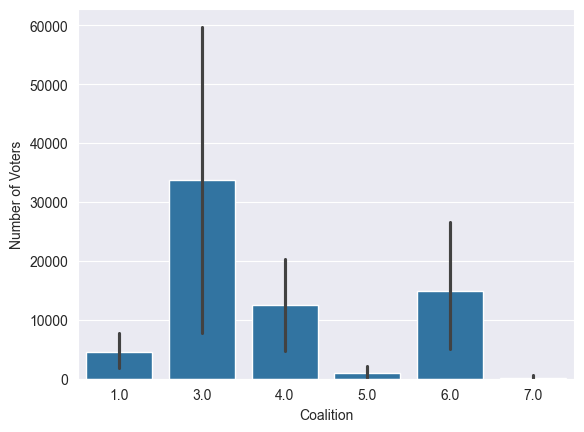

In [401]:
plot = sns.barplot(x = 'coalitionVoter', y = 'nbr_voters', data = tmp1)
plot.set_label('Number of Voters for each coalition')
plot.set_xlabel('Coalition')
plot.set_ylabel('Number of Voters')

Text(24.0, 0.5, 'Number of Proposals voted')

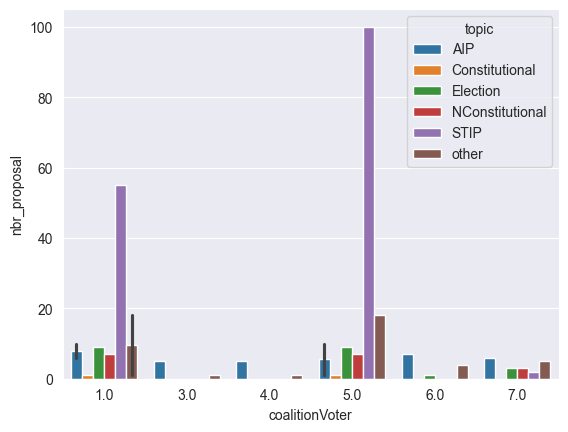

In [403]:
sns.barplot(x = 'coalitionVoter', y = 'nbr_proposal', hue = 'topic' , data = tmp1)
plot.set_label('Number of Proposals for each coalition')
plot.set_xlabel('Coalition')
plot.set_ylabel('Number of Proposals voted')

The insights from the coalition analysis are:
- coalition 1 and 2 are the smallest, containing AIP and other proposals
- coalition 5 is the largest with 44448 unique addreses and 12 propopals. This is driven by voting patterns on AIP proposals. 
- coalition 3 has the largest numbers of proposals (146), most of them STIP

Finally we looked at if the specific coalitin are more likely to vote on a specific topic. 

<Axes: xlabel='topic', ylabel='coalitionVoter'>

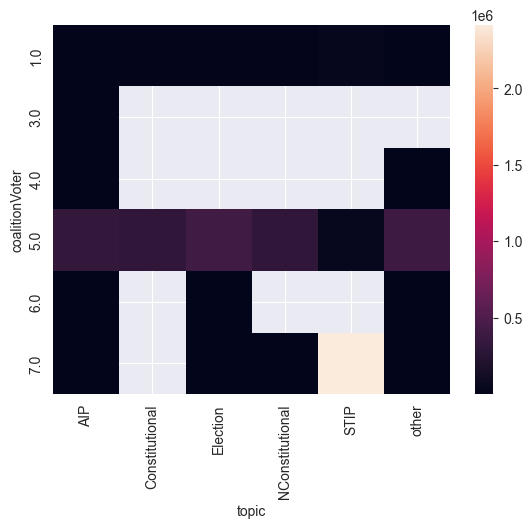

In [406]:
glue = tmp1.pivot_table(index="coalitionVoter", columns="topic", values="avg_vp")
plot = sns.heatmap(glue)
plot.set_label('Is voting power concentrated in a coalition?')
plot.set_xlabel('Proposal Topic')
plot.set_ylabel('Coalition Group')


In this chart voting power distribution has been mapped across Proposal topics and coalition group. It looks like STIP attracted most of the voting power, however, given the number of proposals in this category, we redid the analysis this time without STIP. 

Text(50.722222222222214, 0.5, 'Coalition Group')

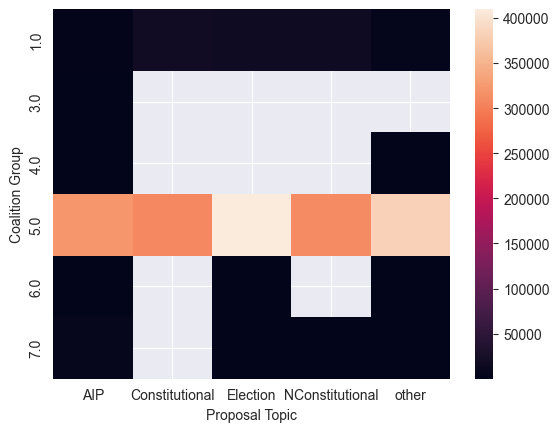

In [407]:
glue = tmp1[tmp1['topic'] != 'STIP'].pivot_table(index="coalitionVoter", columns="topic", values="avg_vp")
plot = sns.heatmap(glue)
plot.set_label('Is voting power concentrated in a coalition?')
plot.set_xlabel('Proposal Topic')
plot.set_ylabel('Coalition Group')

Now it becomes clear that members with a lot of voting power are part of coalition 5. They are most active in the Election voting proposal.

Looking at the distribution of members across coalition groups and voting on proposal topic, we see a good diversity in coalition 1, 5, and 7. Coalition 3 is only composed of new users. This is potentially a problem, as coalition 3 only votes on AIP proposals. They are also only participating on Tally. 

<Axes: xlabel='topic', ylabel='coalitionVoter'>

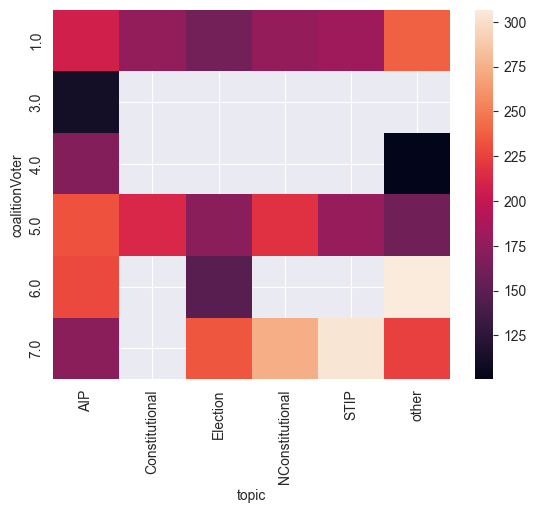

In [404]:
glue = tmp1.pivot_table(index="coalitionVoter", columns="topic", values="active_days")
sns.heatmap(glue)

# Final remarks

